In [208]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from kennard_stone import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) 

In [209]:

dataset = pd.read_csv(path, index_col=0)
Y = dataset.iloc[-1].values
X = dataset.drop(dataset.index[-1], axis=0).values.T
X.shape

(181, 2201)

In [210]:
def nipals(X_original,Y_original, n_components, tol = 1e-10):
    X = X_original.copy()
    Y = Y_original.copy()

    Y = Y.reshape(-1,1)

    scores_X = np.zeros((X.shape[0], n_components))
    scores_Y = np.zeros((X.shape[0], n_components))

    loadings_X = np.zeros((X.shape[1], n_components))
    loadings_Y = np.zeros((Y.shape[1], n_components))

    weights_X = np.zeros((X.shape[1], n_components))
    weights_Y = np.zeros((Y.shape[1], n_components))
    
    for comp in range(n_components):
    
        u = Y[:,0]

        prev_u = u
        for _ in range(500):
            w = X.T@u
            w = w/np.linalg.norm(w)
            w = w.reshape(-1,1)
    
            t = X@w
            t = t.reshape(-1,1)
            
            c = Y.T@t/ (t.T @ t)
    
            u = Y @ c
            u = u.reshape(-1,1)
    
            err = np.linalg.norm(u-prev_u)
            prev_u = u
            
            if err < tol:
                break
        
        p = X.T@t/(t.T@t)
        q = Y.T@t/(t.T@t)

        p = p.reshape(-1,1)

        X = X - t@p.T
        Y = Y - t @ q.T


        scores_X[:, comp] = t[:,0]
        scores_Y[:, comp] = u[:,0]

        loadings_X[:,comp] = p[:,0]
        loadings_Y[:,comp] = q[:,0]
        
        weights_X[:,comp] = w[:,0]
        weights_Y[:,comp] = c[:,0]
    
    return(scores_X, scores_Y, loadings_X, loadings_Y, weights_X, weights_Y)

def PLS_regression(X,Y, max_n_comp, test_size = 0.3, graph = False, verbose = True):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size)
    Y_mean = float(np.mean(Y))
    y_train_centered = y_train - Y_mean
    
    scores_x, scores_y, loadings_x, loadings_y, weights_x, weights_y = nipals(X_train, y_train_centered, n_components = max_n_comp)
    
    
    
    best = np.inf
    n_best = 0
    best_pred = 0
    
    for n in range(1,max_n_comp):
        Wn = weights_x[:,:n]
        Pn = loadings_x[:,:n]
        Qn = loadings_y[:,:n]
    
        Bpls = Wn @ np.linalg.inv(Pn.T@Wn)@Qn.T
    
        y_pred = X_test@Bpls + Y_mean
        
        rmse = root_mean_squared_error(y_test, y_pred)
        if rmse < best:
            best = rmse
            n_best = n
            best_pred = y_pred

    r2 = r2_score(y_test, best_pred)
    if graph:
        plt.scatter(y_test, best_pred)
        plt.xlabel('Test set')
        plt.ylabel('Predictions')
        plt.grid(linestyle=('--'))
        plt.show()

    print(f'weights_x shape: {weights_x.shape}')
    print(f'loadings_x shape: {loadings_x.shape}')
    print(f'scores_xs shape: {scores_x.shape}')
    print(f'RMSE: {np.sqrt(best)}')
    print(f'R²: {r2}')
    print(f'N components: {n_best}')
    

    return(Bpls[:,:n_best], scores_x, loadings_x)

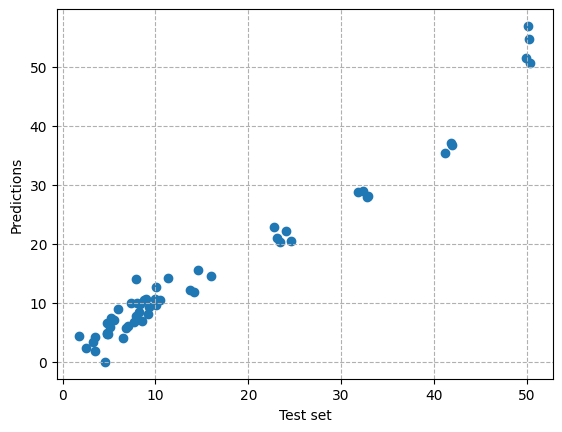

weights_x shape: (2201, 15)
loadings_x shape: (2201, 15)
scores_xs shape: (126, 15)
RMSE: 1.6430823190067958
R²: 0.9640790733191462
N components: 7
0.13898682594299316


In [211]:
X_scaled = StandardScaler().fit_transform(X)

start = time.time()
coeff, scores, loadings = PLS_regression(X_scaled,Y, 15, graph=True)
end = time.time()
delta = end - start
print(delta)

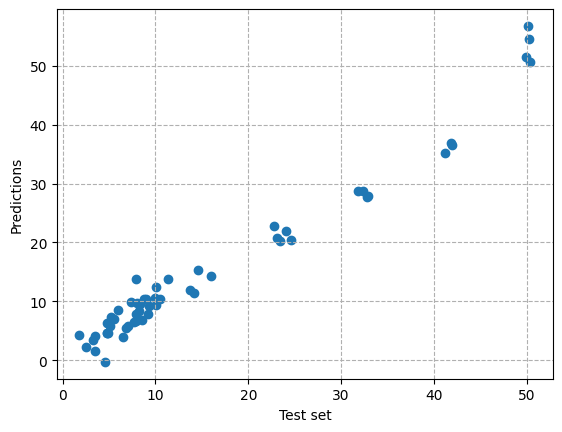

RMSE: 1.6495406443438154
R²: 0.9635109693220831
N components: 7
0.11604738235473633


In [212]:
start = time.time()
pls = PLSRegression(n_components = 7)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)


r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Test set')
plt.ylabel('Predictions')
plt.grid(linestyle=('--'))
plt.show() 

print(f'RMSE: {np.sqrt(rmse)}')
print(f'R²: {r2}')
print(f'N components: {7}')

end = time.time()
delta = end - start
print(delta)
